In [2]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torchvision.transforms.functional as TF
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm


In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            #same conv
            nn.Conv2d(in_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channel=3, out_channel=1, features=[64, 128,256, 512, 1024]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #encoder
        for feature in features:
            self.encoder.append(DoubleConv(in_channel, feature))
            in_channel = feature

        #decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature, feature//2, kernel_size=2, stride=2)
            )
            self.decoder.append(DoubleConv(feature, feature//2))

        self.final_conv = nn.Conv2d(features[0], out_channel, kernel_size=1)


    def forward(self, x):
        skip_connections = []

        for enc in self.encoder:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)
        skip_connections.pop()
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            if idx//2 >= len(skip_connections):
                break
            x = self.decoder[idx](x)
            skip_con = skip_connections[idx//2]
            if x.shape != skip_con.shape:
                x = TF.resize(x, size=skip_con.shape[2:])
            concat_skip = torch.cat((skip_con, x), dim=1)
            x = self.decoder[idx+1](concat_skip)

        return self.final_conv(x)



In [4]:
def test():
    inp = torch.randn((10, 3, 161, 161))
    model = UNet()
    out = model(inp)
    print(inp.shape)
    print(out.shape)

test()

torch.Size([10, 3, 161, 161])
torch.Size([10, 1, 161, 161])


In [5]:
class CarDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor()
        ])
        self.images = os.listdir(image_dir)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", "_mask.gif"))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        return self.transform(image), self.transform(mask)
            

In [6]:
print(os.listdir("../input/carvana-image-masking-challenge/"))


['train_masks.zip', '29bb3ece3180_11.jpg', 'train_masks.csv.zip', 'train.zip', 'metadata.csv.zip', 'sample_submission.csv.zip', 'test.zip', 'test_hq.zip', 'train_hq.zip']


In [7]:
DATASET_DIR = '../input/carvana-image-masking-challenge/'
WORKING_DIR = '/kaggle/working/'

In [8]:
if len(os.listdir(WORKING_DIR)) <= 1:
    
    with zipfile.ZipFile(DATASET_DIR + 'train.zip', 'r') as zip_file:
        zip_file.extractall(WORKING_DIR)

    with zipfile.ZipFile(DATASET_DIR + 'train_masks.zip', 'r') as zip_file:
        zip_file.extractall(WORKING_DIR)

    print(
        len(os.listdir(WORKING_DIR + 'train')),
        len(os.listdir(WORKING_DIR + 'train_masks'))
    )

In [9]:
train_dataset = CarDataset(WORKING_DIR+'train', WORKING_DIR+'train_masks')

In [10]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5])

(tensor([[[0.9333, 0.9333, 0.9333,  ..., 0.9412, 0.9412, 0.9412],
         [0.9333, 0.9333, 0.9333,  ..., 0.9412, 0.9412, 0.9412],
         [0.9333, 0.9333, 0.9333,  ..., 0.9412, 0.9412, 0.9412],
         ...,
         [0.6549, 0.6549, 0.6549,  ..., 0.6706, 0.6745, 0.6745],
         [0.6549, 0.6549, 0.6549,  ..., 0.6706, 0.6745, 0.6745],
         [0.6549, 0.6549, 0.6549,  ..., 0.6706, 0.6745, 0.6745]],

        [[0.9373, 0.9373, 0.9373,  ..., 0.9412, 0.9412, 0.9412],
         [0.9373, 0.9373, 0.9373,  ..., 0.9412, 0.9412, 0.9412],
         [0.9373, 0.9373, 0.9373,  ..., 0.9412, 0.9412, 0.9412],
         ...,
         [0.6706, 0.6706, 0.6706,  ..., 0.6863, 0.6902, 0.6902],
         [0.6706, 0.6706, 0.6706,  ..., 0.6863, 0.6902, 0.6902],
         [0.6706, 0.6706, 0.6706,  ..., 0.6863, 0.6902, 0.6902]],

        [[0.9176, 0.9176, 0.9176,  ..., 0.9412, 0.9412, 0.9412],
         [0.9176, 0.9176, 0.9176,  ..., 0.9412, 0.9412, 0.9412],
         [0.9176, 0.9176, 0.9176,  ..., 0.9412, 0.9412, 0

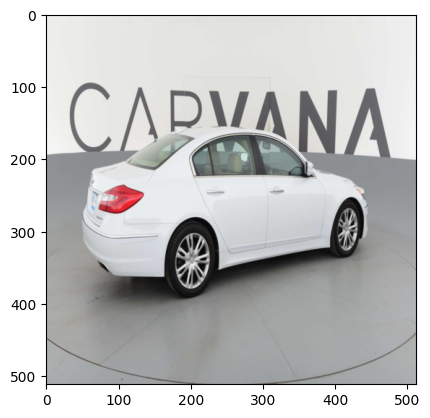

In [11]:
img = train_dataset[0]
print(img)
imgPIL = img[0].permute(1,2,0)
maskPIL = img[1].permute(1,2,0)
imgPIL.size()
plt.imshow(imgPIL.numpy())



In [12]:
os.cpu_count()

4

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    NUM_WORKERS = torch.cuda.device_count() * min(4, os.cpu_count())
else: 
    NUM_WORKERS = min(4, os.cpu_count())

In [14]:
device

'cuda'

In [15]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8
PIN_MEMORY = False
SHUFFLE = True

In [16]:
from functools import partial

setup_dataloader = partial(DataLoader, 
                           num_workers=NUM_WORKERS,
                           pin_memory=PIN_MEMORY,
                           batch_size=BATCH_SIZE,
                           shuffle=SHUFFLE
                          )

In [17]:
model = UNet(in_channel=3, out_channel=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [18]:
torch.cuda.empty_cache()


In [19]:
train_dataloader = setup_dataloader(dataset=train_dataset)
val_dataloader = setup_dataloader(dataset=val_dataset)
test_dataloader = setup_dataloader(dataset=test_dataset)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
def trainUNet(epochs):
    EPOCHS = epochs

    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_running_loss = 0
        
        for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            
            y_pred = model(img)
            optimizer.zero_grad()
            
            loss = criterion(y_pred, mask)
            
            train_running_loss += loss.item()
    
            loss.backward()
            optimizer.step()
    
        train_loss = train_running_loss / (idx + 1)
        
        train_losses.append(train_loss)
    
        model.eval()
        val_running_loss = 0
        
        with torch.no_grad():
            for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
                img = img_mask[0].float().to(device)
                mask = img_mask[1].float().to(device)
    
                y_pred = model(img)
                loss = criterion(y_pred, mask)
                
                val_running_loss += loss.item()
    
            val_loss = val_running_loss / (idx + 1)
        
        val_losses.append(val_loss)
    
        print("-" * 30)
        print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print("\n")
        print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print("-" * 30)
    
    # Saving the model
    torch.save(model.state_dict(), 'my_checkpoint.pth')
    return train_losses, val_losses

In [21]:
EPOCHS = 1
train_losses, val_losses = trainUNet(EPOCHS)


100%|██████████| 1/1 [19:06<00:00, 1146.85s/it]


------------------------------
Training Loss EPOCH 1: 0.1179


Validation Loss EPOCH 1: 0.0390
------------------------------


In [22]:
def random_images_inference(image_tensors, mask_tensors, model_pth, device):
    model = UNet(in_channel=3, out_channel=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((512, 512))
    ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth in zip(image_tensors, mask_tensors):
        # Load the image
        img = transform(image_pth)
        
        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)
        
        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)
                
        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1
        
        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.subplot(133), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.show()

In [23]:
n = 10 

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])
    mask_tensors.append(random_sample[1])

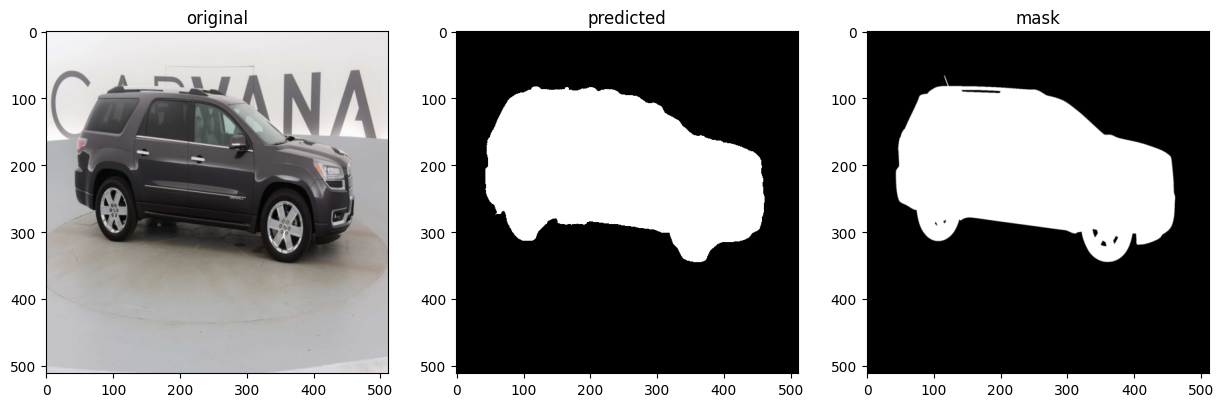

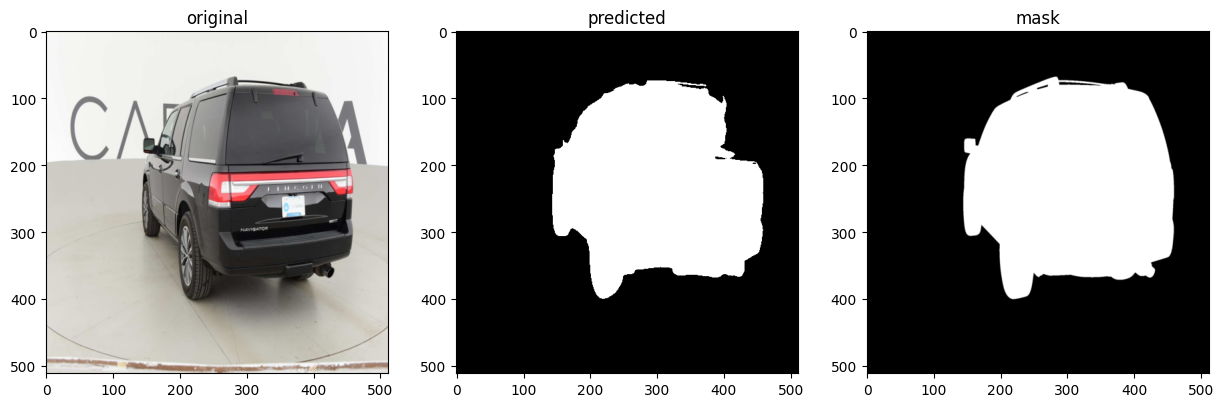

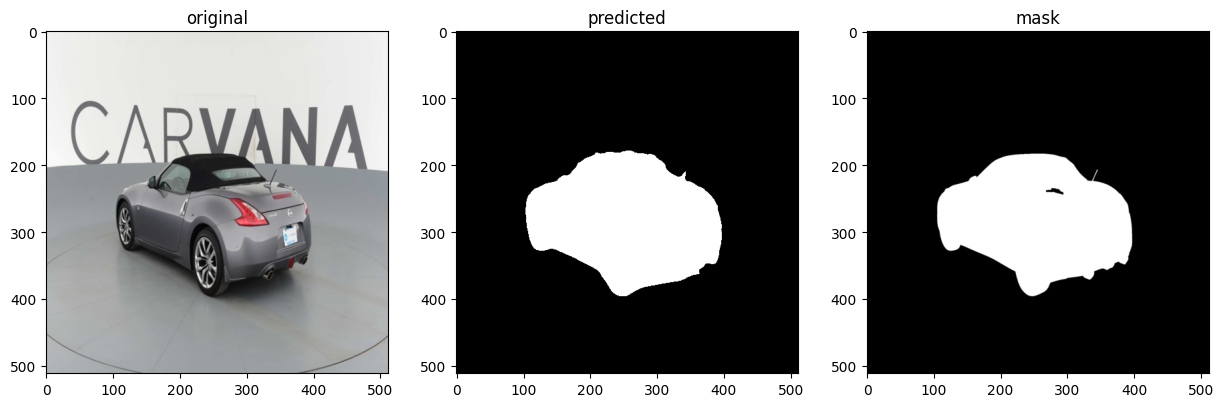

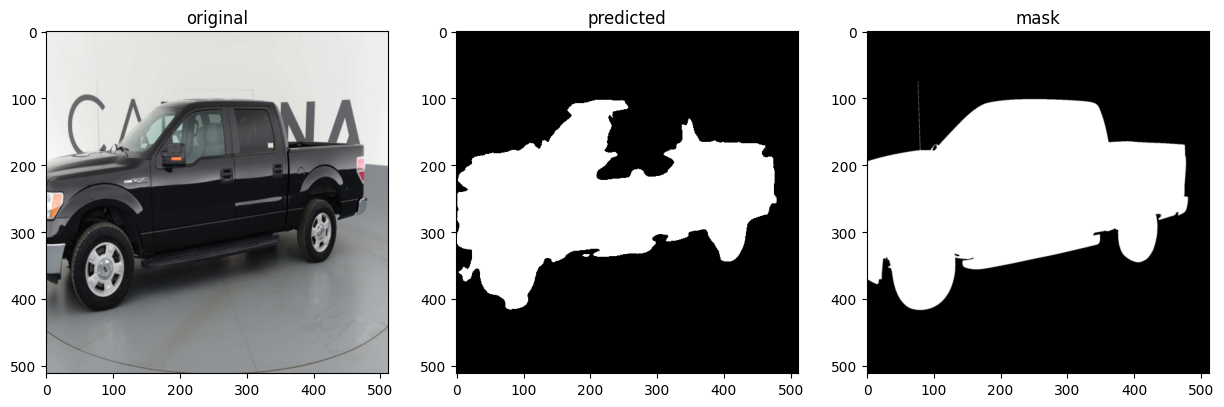

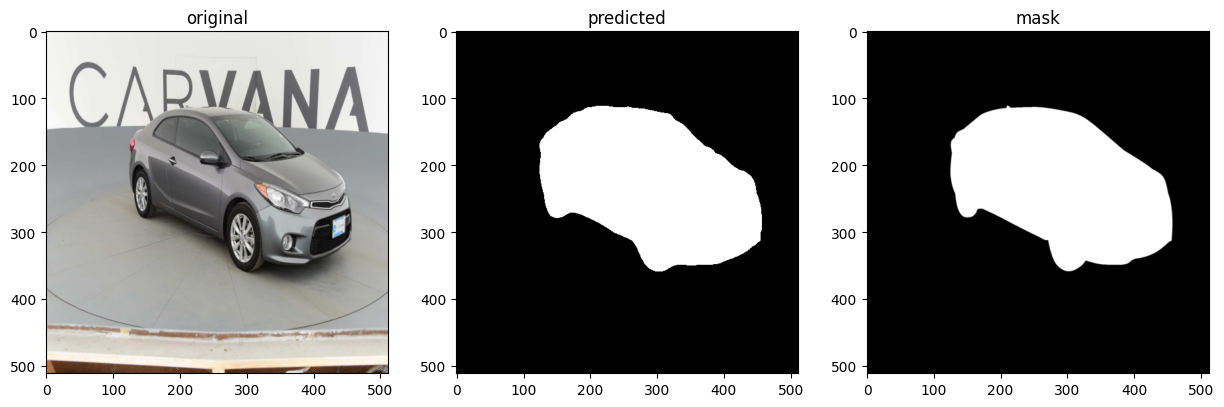

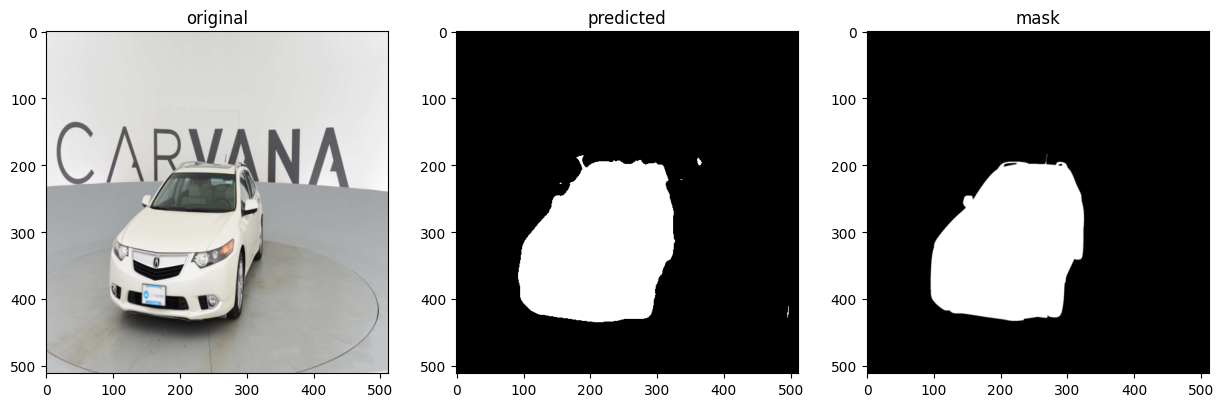

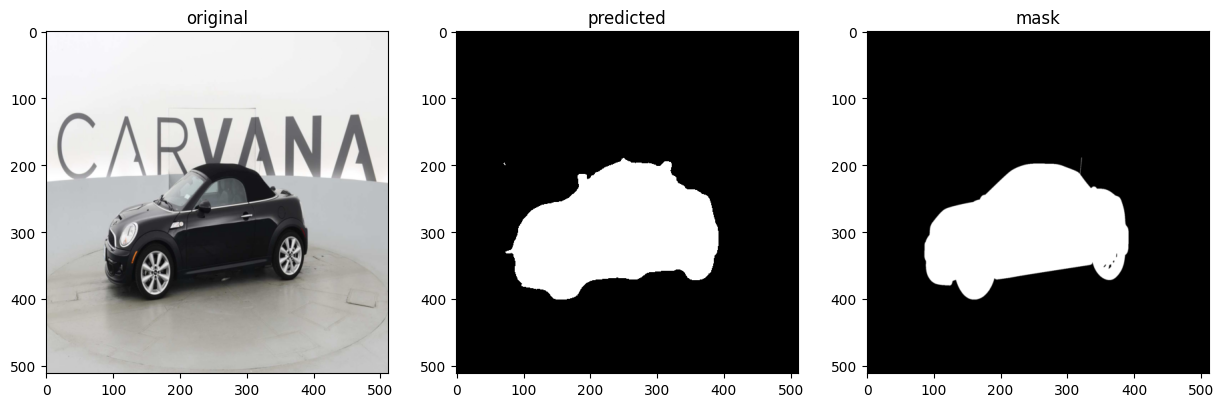

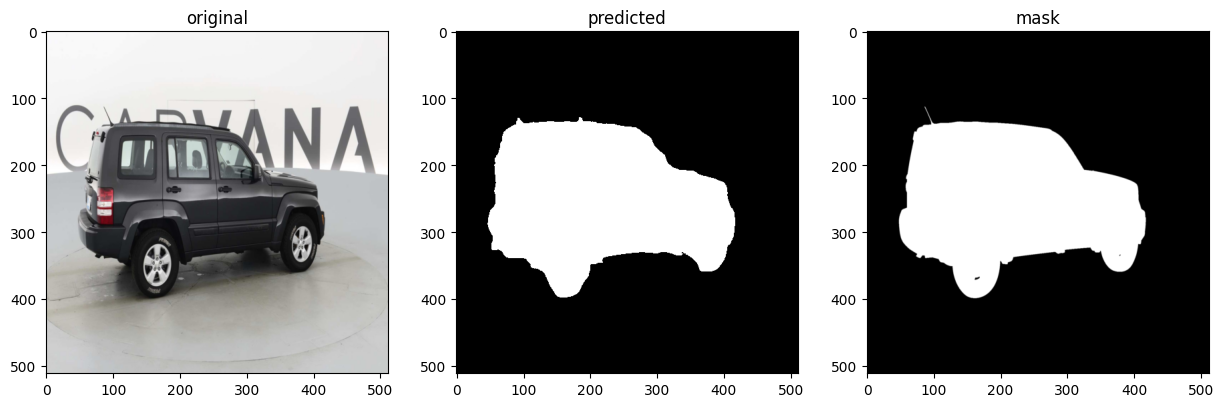

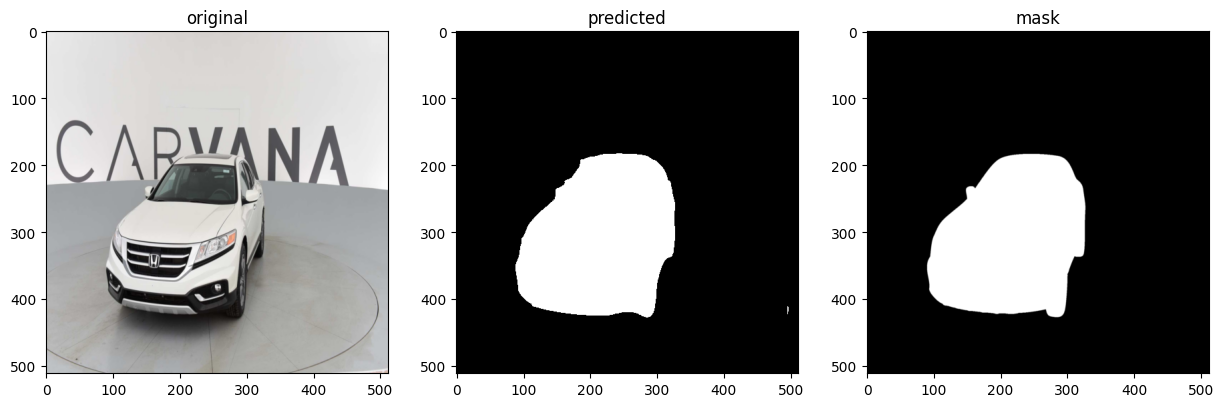

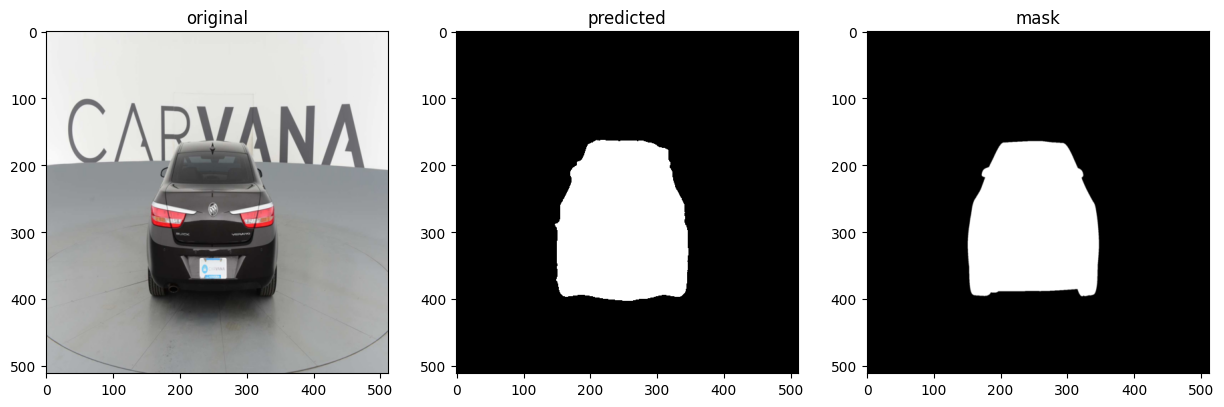

In [24]:
model_path = '/kaggle/working/my_checkpoint.pth'

random_images_inference(image_tensors, mask_tensors, model_path, device="cpu")